In [1]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
from RNN_model import SimpleRNN
import utils_2 as ut2
from traindata import trainData



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file1_080124.mat"
#cutoff = [8/1000, 11/1000]

data = trainData(fpath, fname, 'Amplitude')
train, val, test = data.split_data('Amplitude')

In [3]:
train = utils.subsample(train, 2)
val = utils.subsample(val, 2)
test = utils.subsample(test, 2)

In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
val_scaled = scaler.transform(val.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [14]:
x_train, y_train = ut2.create_sequences(train_scaled[:10000], 1000, 1)
x_val, y_val = ut2.create_sequences(val_scaled[:5000], 1000, 1)
x_test, y_test = ut2.create_sequences(test_scaled[:3000], 1000, 1)

In [15]:
'''x_train, y_train = ut2.create_sequences(train_scaled[:200000], 1000, 1)
x_val, y_val = ut2.create_sequences(val_scaled[:45000], 1000, 1)
x_test, y_test = ut2.create_sequences(test_scaled[:45000], 1000, 1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape'''

'x_train, y_train = ut2.create_sequences(train_scaled[:200000], 1000, 1)\nx_val, y_val = ut2.create_sequences(val_scaled[:45000], 1000, 1)\nx_test, y_test = ut2.create_sequences(test_scaled[:45000], 1000, 1)\n\nx_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape'

In [16]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((9000, 1000, 1),
 (9000, 1),
 (4000, 1000, 1),
 (4000, 1),
 (2000, 1000, 1),
 (2000, 1))

In [17]:
x_train = torch.from_numpy(x_train.astype(np.float32)).squeeze()
y_train = torch.from_numpy(y_train.astype(np.float32)).squeeze()
x_val = torch.from_numpy(x_val.astype(np.float32)).squeeze()
y_val = torch.from_numpy(y_val.astype(np.float32)).squeeze()
x_test = torch.from_numpy(x_test.astype(np.float32)).squeeze()
y_test = torch.from_numpy(y_test.astype(np.float32)).squeeze()


In [18]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([9000, 1000]),
 torch.Size([9000]),
 torch.Size([4000, 1000]),
 torch.Size([4000]),
 torch.Size([2000, 1000]),
 torch.Size([2000]))

In [19]:
def rolling_window(data, window_size):
    # Reshape the data into overlapping sequences of window_size
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

## **Single Step**

In [20]:
in_size = x_train.shape[-1]
out_size = 1
hid_size = 3
num_layers = 1


model = SimpleRNN(in_size, hid_size, out_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:17<00:25,  4.28s/it]

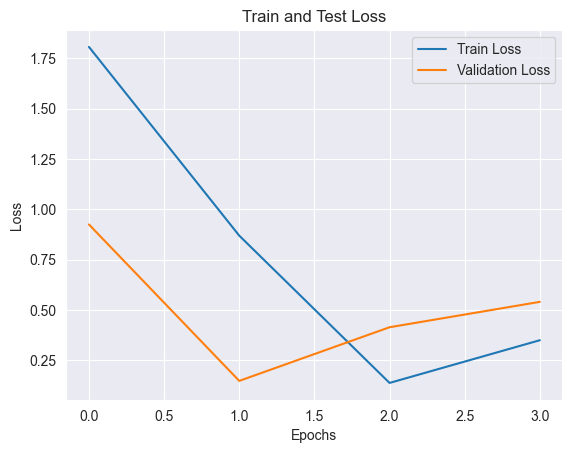

 50%|█████     | 5/10 [00:21<00:22,  4.41s/it]

Epoch :0.5    Train Loss :0.4755081236362457    Test Loss :0.508047342300415


 90%|█████████ | 9/10 [00:38<00:04,  4.23s/it]

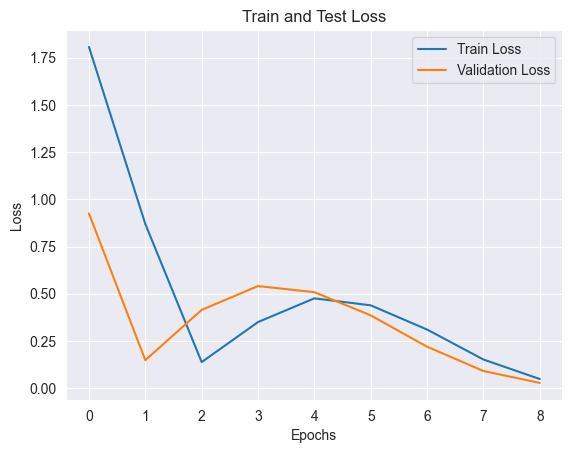

100%|██████████| 10/10 [00:43<00:00,  4.32s/it]

Epoch :1.0    Train Loss :0.01757822185754776    Test Loss :0.014243719168007374


In [21]:
train_loss, test_loss = ut2.simpleTrain_model(model,
                                            criterion,
                                            optimizer,
                                            x_train,
                                            x_val,
                                            y_train,
                                            y_val,
                                            epochs=10)

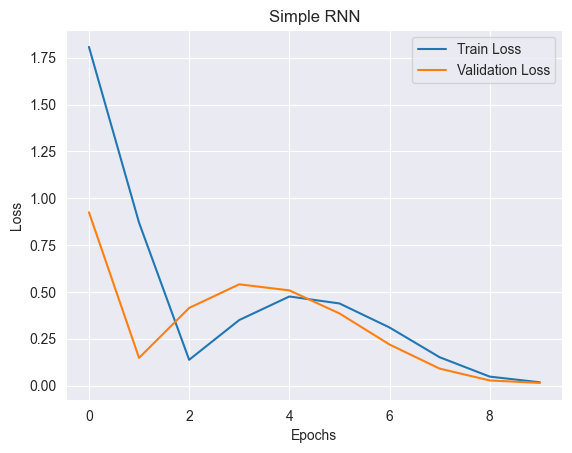

In [22]:
ut2.plot_loss(train_loss, test_loss, 'Simple RNN')

### **test prediction with rolling window**

In [23]:
test_pred = ut2.rollingWindowPrediction(model, x_test, steps = 50)

100%|██████████| 2000/2000 [00:33<00:00, 59.79it/s]


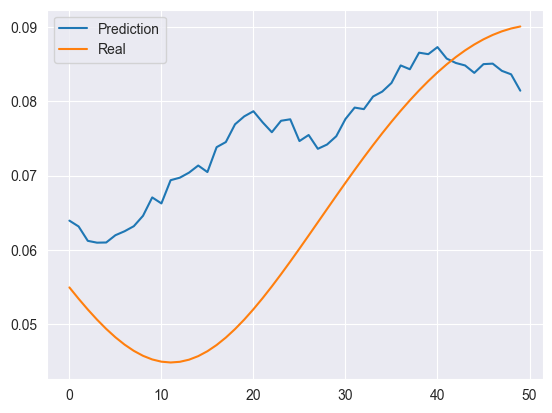

In [24]:
plt.plot(test_pred[-1], label='Prediction')
plt.plot(y_test[-50:].numpy(), label='Real')
plt.legend()
plt.show()

## **Errores**

In [25]:
import errores as er
x = er.error_metrics(test_pred[:-49], test_scaled[:3000], 50)

Mean Squared Error: 0.0033441296518797003
Mean Absolute Percentage Error: 0.6354183569193537
R2 Score: -1.7201577017780254
Root Mean Squared Error: 0.057759489167560546


### **best model re-training**

In [26]:
np.argmin(test_loss), np.min(test_loss)

(9, 0.014243719168007374)

In [28]:
# 
utils.resume(model, optimizer, 'checkpoint_4.pth' )